In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import time
import os
#from google.colab.patches import cv2_imshow
print(cv2.__version__)

4.5.3


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LambdaCallback
from keras.callbacks import ModelCheckpoint
import pandas as pd
import keras

In [3]:
def process_seq():
    global seq
    

In [3]:
def vgg13_model(n_classes):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), strides=(1, 1), input_shape=(64, 64, 1), padding='same', activation='relu',
                     kernel_initializer='glorot_uniform'))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='glorot_uniform'))
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))
    return model

In [4]:
model = vgg13_model(8)
model.load_weights('./data/model_40-0.80.hdf5')

In [5]:
classNames      = {0: 'no_face',
                   1: 'face'}

prototxt        = './data/MobileNetSSD_deploy.prototxt'
caffemodel      = './data/MobileNetSSD_deploy.caffemodel'
#net             = cv2.dnn.readNetFromCaffe(prototxt, caffemodel)
net             = cv2.dnn.readNetFromCaffe("./data/deploy.prototxt","./data/res10_300x300_ssd_iter_140000_fp16.caffemodel")
print("caffemodel '", caffemodel, "' loaded")

caffemodel ' ./data/MobileNetSSD_deploy.caffemodel ' loaded


In [64]:
videopath       = './data/test.mp4'
emotion_dict = {0: "neutral", 1: "happiness", 2: "surprise", 3: "sadness", 4: "anger", 5: "disgust", 6: "fear", 7: "contempt"}
video           = cv2.VideoCapture(videopath)
# video           = cv2.VideoCapture(0)
scoreThres      = 0.3
W               = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
H               = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
strat_time = time.time()
count = 0
e_que = [[[],[]],[[],[]],[[],[]],[[],[]]]
r_list = [[],[],[],[]]
while True: 
    count += 1
    calc_ex = 0
    (grabbed,frame) = video.read()
    strat_time = time.time()
    if not grabbed:
        break
    output = frame
    blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0,(300, 300), (104.0, 177.0, 123.0))
    rows = blob.shape[2]
    cols = blob.shape[3]
    net.setInput(blob)
    pred = net.forward()
    numOfObjects= pred.shape[2]
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    if(count % 25 == 0):
        c_t = int(count / 25)
        calc_ex = 1
    for i in range(numOfObjects):
        confidence = pred[0, 0, i, 2]
        if confidence > scoreThres:
            classId = int(pred[0, 0, i, 1])
            x1 = int(pred[0, 0, i, 3] * cols) 
            y1 = int(pred[0, 0, i, 4] * rows)
            x2 = int(pred[0, 0, i, 5] * cols)
            y2 = int(pred[0, 0, i, 6] * rows)
            hFactor = H/300.0 
            wFactor = W/300.0
            x1 = int(wFactor*x1) 
            y1 = int(hFactor*y1)
            x2 = int(wFactor*x2)
            y2 = int(hFactor*y2)
            x = x1
            y = y1
            w = x2-x1
            h = y2-y1
            #expression detection
            p_id = 0
            c_x = (x1 + x2)/2
            c_y = (y1 + y2)/2
            if(c_x > W/2):
                if(c_y > H/2):
                    p_id = 3
                else:
                    p_id = 1
            else:
                if(c_y > H/2):
                    p_id = 2
                else:
                    p_id = 0
            roi_gray = gray[y:y + h, x:x + w]
            cropped_img=cv2.resize(roi_gray,(64,64), interpolation=cv2.INTER_LINEAR)
            input_data=np.array(cropped_img)
            input_data = input_data.reshape(-1, 64, 64, 1)
            pre_m = model(input_data,training = False)
            prediction = np.array(pre_m)
            #prediction = model.predict(input_data)
            maxindex1 = int(np.argmax(prediction))
            promax1 = prediction[0,maxindex1]
            r_list[p_id].append(maxindex1)
            if(calc_ex == 1):
                if(len(r_list[p_id]) > 0):
                    num_temp = np.argmax(np.bincount(r_list[p_id]))
                    e_que[p_id][0].append(c_t)
                    e_que[p_id][1].append(num_temp)
                    r_list[p_id] = []
            cv2.putText(output, str(p_id)+":"+ emotion_dict[maxindex1] + "{:.2f}".format(promax1), (x-1, y+30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
            ####
            txtlbl = "{} : {:.2f}".format(classNames[classId],confidence)
            txtsize = cv2.getTextSize(txtlbl,
                                    cv2.FONT_HERSHEY_SIMPLEX,
                                    0.5,
                                    1)
            bsize = txtsize[0]
            bsline = txtsize[1]
            cv2.rectangle(output, (x,y),(x+w,y+h),(0, 255, 0),2)
    tt = 1 / (time.time() - strat_time)
    cv2.putText(output,
                    "FPS:" + str(tt),
                    (70,40),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    2,
                    (0, 0, 0),
                    1,
                    cv2.LINE_AA)
    cv2.imshow("SSD detection",output)
    k = cv2.waitKey(1) & 0xff
    if k == 27:
        break

video.release()
cv2.destroyAllWindows()

In [23]:
stress_level = {0: "HS", 1: "LS", 2: "N", 3: "LH", 4: "HH"}

In [24]:
emotion_tostress = {0: 2, 1: 3, 2: 4, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1}
#emotion_dict = {0: "neutral", 1: "happiness", 2: "surprise", 3: "sadness", 4: "anger", 5: "disgust", 6: "fear", 7: "contempt"}

In [28]:
# for id in range(4):
#     for state in range(len(e_que[id][1])):
#         e_que[id][1][state] = emotion_tostress[e_que[id][1][state]]

In [25]:
len(e_que[1][1])

14

In [26]:
import numpy as np
from hmmlearn import hmm
 
n_states = 5
 
start_probability = np.array([0.1, 0.1, 0.6, 0.1, 0.1])
 
transition_probability = np.array([  #  HH   LH   N    LS   HS
  [0.2, 0.4, 0.2, 0.1, 0.1],
  [0.2, 0.4, 0.2, 0.1, 0.1],
  [0.1, 0.2, 0.4, 0.2, 0.1],
  [0.1, 0.1, 0.2, 0.4, 0.2],
  [0.1, 0.1, 0.2, 0.4, 0.2]
])

emission_probability = np.array([     #{0: "neutral", 1: "happiness", 2: "surprise", 3: "sadness", 4: "anger", 5: "disgust", 6: "fear", 7: "contempt"}
  [0.1, 0.3, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0],#HH
  [0.2, 0.6, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0],#LH
  [0.4, 0.15, 0.05, 0.15, 0.05, 0.05, 0.05, 0.1],#N
  [0.1, 0.0, 0.0, 0.3, 0.1, 0.1, 0.1, 0.3],#LS
  [0.1, 0.0, 0.0, 0.15, 0.2, 0.2, 0.2, 0.15] #HS
])
 
hmmmodel = hmm.MultinomialHMM(n_components=n_states)
hmmmodel.startprob_=start_probability
hmmmodel.transmat_=transition_probability
hmmmodel.emissionprob_=emission_probability
 
seen = np.array([e_que[1][1]]).T
print(hmmmodel.predict(seen))

[2 2 2 2 2 2 2 2 2 2 2 2 1 1]


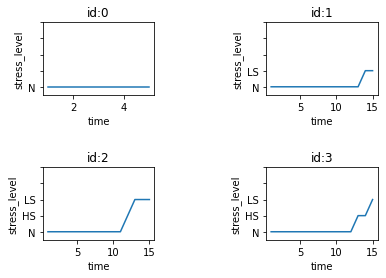

In [63]:
# from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import MultipleLocator
seen = []
result = []
for id in range(4):
    # print(e_que[id][1])
    seen.append([e_que[id][1]])


for i in range(len(seen)):
    # print(hmmmodel.predict(np.array(seen[i]).T))
    result.append(hmmmodel.predict(np.array(seen[i]).T))
result

#represent stress
result_list=list(result)
stress=[]
for id in range(len(result_list)):
    print(id)
    stress_id=[]
    for i in range(len(result_list[id])):
        
        print(stress_level[result_list[id][i]])
        stress_id.append(stress_level[result_list[id][i]])
    stress.append(stress_id)
stress
plt.figure()
for id in range(4):
    
    plt.subplot(2,2,id+1)
    plt.plot(e_que[id][0], stress[id])
    plt.xlabel("time")
    plt.ylabel("stress_level")
    plt.title("id:"+str(id))
    y_major_locator=MultipleLocator(1)
    ax=plt.gca()
    ax.yaxis.set_major_locator(y_major_locator)
    plt.ylim(-0.5,4)
# plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
# fig.tight_layout()
plt.subplots_adjust(wspace =1,hspace =1)
plt.show()  